In [88]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import numpy as np
plt.style.use('dark_background')

In [89]:
gang = pd.read_csv('../data/data_big_june2015/gang_data.csv')
gang['Timestamp']=pd.to_datetime([val.rsplit('-',1)[0] for val in gang['Timestamp']])

In [95]:
#generating idle time data
n = 0
save_hist = np.zeros((gang['Timestamp'].shape[0],17))
save_hist_pernode = []
stackit = []
runcnt = []
X = []
for index in range(1,700):
    pick = 'midway'+str(index).zfill(3)
    sub = pick+'|Timestamp'  
    subgang = gang.filter(regex=sub)
    subgang.columns=["".join(col.lstrip(pick).split()) for col in subgang.columns]
    if('domain_a_avgpwr' in subgang):
        dat = subgang['Timestamp'].values
        val = subgang['proc_run'].values
        val[np.isnan(val)]=0.1
        norun = (val==0)
        runl = 0
        for ix in range(len(norun)):
            i = norun[ix]
            if(i):
                if(runl==0):
                    tstmp = pd.Timestamp(dat[ix])
                    toadd=[index,tstmp.dayofweek,tstmp.hour,tstmp.month]
                runl=runl+1
            else:
                if(runl>0):
                    X.append(toadd)
                    runcnt.append(runl)
                    runl=0
X = np.array(X)
tstep = (gang['Timestamp'][1]-gang['Timestamp'][0]).seconds
ttot = (gang['Timestamp'].iloc[-1]-gang['Timestamp'][0]).days+(gang['Timestamp'].iloc[-1]-gang['Timestamp'][0]).seconds/3600./24.
Y = np.array(runcnt)*tstep/60.0/60.0

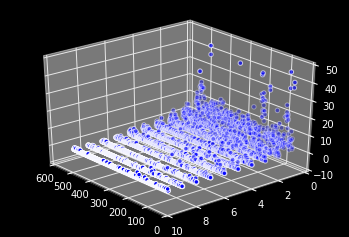

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
save = []
cost = []
for i in set(X[:,0]):
    tmcnt = Y[X[:,0]==i] #Y[np.logical_and(X[:,0]==i, X[:,1]==1)]
    hist, bins = np.histogram(tmcnt, bins=10, range=[0,10])
    center = (bins[:-1] + bins[1:]) / 2
    ax.scatter(i*np.ones(len(hist)),center, hist)
    cutoff=center[0]
    tmsave=(np.sum(tmcnt[tmcnt>cutoff]-cutoff))
    tmcost=(np.sum(tmcnt>cutoff)*10./60) #10 minutes for every time a node shutsoff
    save.append((tmsave-tmcost)*55/1000/ttot) #total hours*55W/12 days 
    cost.append(tmcost*250/1000/ttot) #total hours*255W/12 days 
ax.set_ylim(0,10)
ax.view_init(30, 140)
plt.draw()
plt.figure()

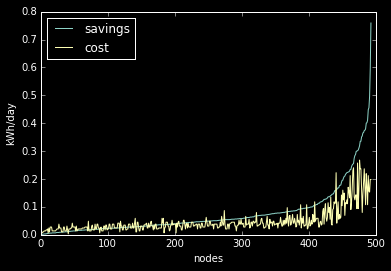

In [97]:
[s,c]=zip(*sorted(zip(save,cost)))
plt.plot(s,label='savings')
plt.plot(c,label='cost')
plt.legend(loc=2)
plt.xlabel('nodes')
plt.ylabel('kWh/day')


In [100]:
S = np.array(s)
C = np.array(c)
print "save "+str(np.sum(S-C))+" kWh/day shutting off all nodes"
print "save "+str(np.sum(S[S>C]-C[S>C]))+" kWh/day shutting off only the nodes that don't get used enough"

save 13.6866782609 kWh/day shutting off all nodes
save 15.2546086957 kWh/day shutting off only the nodes that don't get used enough
